In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import re  # For preprocessing
from time import time  # To time our operations
from collections import defaultdict  # For word frequency



import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [4]:
df = pd.read_csv("drive/MyDrive/uniprot links.csv")

In [5]:
interactions_df=df[['DrugBank ID','UniProt ID']]

In [6]:
interaction_edge_list=interactions_df.rename(columns={'DrugBank ID': 'compound_1','UniProt ID': 'compound_2'})

In [7]:
interaction_edge_list.insert(2,"label",1)

In [8]:
DDS_df = pd.read_csv("drive/MyDrive/drug_similarity_df_TH.csv")

In [ ]:
DDS_df.loc["DB00001"]

In [9]:
DDS_df=DDS_df.rename(columns={'compound0': 'compound_1','compound1': 'compound_2','similarity':'label'})

In [10]:
interaction_DDS_Edge_list=interaction_edge_list.append(DDS_df,ignore_index=True)

In [11]:
PPS_df = pd.read_csv("drive/MyDrive/Graph EdgeList/protien_similarity_threshold_df.csv")

In [12]:
PPS_df=PPS_df.rename(columns={'compound0': 'compound_1','compound1': 'compound_2','similarity':'label'})

In [13]:
all_edge_list_df=interaction_DDS_Edge_list.append(PPS_df,ignore_index=True)

In [14]:
all_edge_list_df.head(-5)

,compound_1,compound_2,label
0,DB00001,P00734,1.000000
1,DB00002,P00533,1.000000
2,DB00002,O75015,1.000000
3,DB00002,P02745,1.000000
4,DB00002,P02746,1.000000
...,...,...,...
20738,O00763,Q13085,0.736371
20739,Q9UI33,Q15858,0.556338
20740,Q9UI33,Q99250,0.555112
20741,Q9UI33,Q14524,0.564980


In [15]:
all_edge_list_df.to_csv('drive/MyDrive/all_edge_list_df.csv')

In [16]:
G = nx.Graph()
G=nx.from_pandas_edgelist(all_edge_list_df,"compound_1","compound_2","label",create_using=nx.Graph())
len(G)

4864

In [17]:
G.number_of_edges()

20450

{}

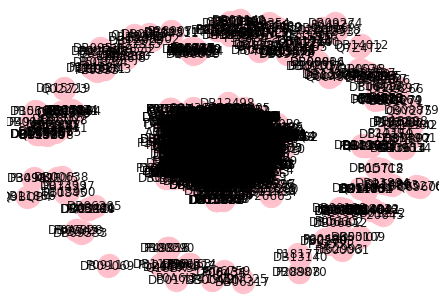

In [18]:
'''
#nx.draw(G,with_labels = True)
pos = nx.spring_layout(G)
nx.draw(G,pos,edge_color='black',width=1,linewidths=1,node_size=500,node_color='pink',alpha=0.9,
        labels={node:node for node in G.nodes()})
nx.draw_networkx_edge_labels(G,pos,edge_labels={},font_color='red')
'''

In [19]:
def get_randomwalk(node, path_length):
    
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [20]:
all_nodes = list(G.nodes())

In [21]:
len(G.nodes())

4864

In [22]:
random_walks = []

for n in tqdm(all_nodes):
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))

100%|██████████| 4864/4864 [00:01<00:00, 4434.33it/s]


In [ ]:
random_walks[0:20]

In [ ]:
len(random_walks)

24320

In [24]:
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

INFO - 21:52:52: 'pattern' package not found; tag filters are not available for English


In [ ]:
model = Word2Vec(window = 4, sg = 1, hs = 1,
                 size=64,
                 negative = 0, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(random_walks, progress_per=2)

In [27]:
t = time()
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 21:55:46: training model with 3 workers on 4864 vocabulary and 64 features, using sg=1 hs=1 sample=0.001 negative=0 window=4
INFO - 21:55:47: worker thread finished; awaiting finish of 2 more threads
INFO - 21:55:47: worker thread finished; awaiting finish of 1 more threads
INFO - 21:55:47: worker thread finished; awaiting finish of 0 more threads
INFO - 21:55:47: EPOCH - 1 : training on 190699 raw words (188705 effective words) took 0.6s, 319785 effective words/s
INFO - 21:55:48: worker thread finished; awaiting finish of 2 more threads
INFO - 21:55:48: worker thread finished; awaiting finish of 1 more threads
INFO - 21:55:48: worker thread finished; awaiting finish of 0 more threads
INFO - 21:55:48: EPOCH - 2 : training on 190699 raw words (188741 effective words) took 0.6s, 313279 effective words/s
INFO - 21:55:48: worker thread finished; awaiting finish of 2 more threads
INFO - 21:55:48: worker thread finished; awaiting finish of 1 more threads
INFO - 21:55:48: worker thread

Time to train the model: 0.2 mins


In [28]:
d={}
for n in G.nodes():
    d[n]=model[n].tolist()

In [ ]:
sims = model.wv.most_similar('O00238', topn=10)  # get other similar words
print(sims)

INFO - 17:32:24: precomputing L2-norms of word weight vectors


[('P36896', 0.900877833366394), ('Q04771', 0.8839342594146729), ('P36894', 0.874199628829956), ('P36897', 0.8690418601036072), ('DB11639', 0.7766237258911133), ('Q13873', 0.7502298355102539), ('Q12866', 0.631093442440033), ('Q52WX2', 0.6017159223556519), ('Q9H3Y6', 0.593721866607666), ('DB12010', 0.5914381146430969)]


In [ ]:
emb=pd.DataFrame.from_dict(d)

In [ ]:
emb_transposed = emb.T

In [ ]:
emb_transposed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
DB00001,-0.540512,0.092158,0.207670,0.862200,0.027477,0.264244,-0.318120,0.782379,0.528775,-0.555405,-0.564396,-0.962679,0.436289,0.458397,-0.726142,0.210273,0.508895,-0.257994,-0.155563,0.070200,-0.559980,-0.055086,0.501433,-0.610794,0.200147,-0.130834,-0.459934,0.219171,-0.446948,0.844013,0.498319,0.160801,0.289337,1.255532,-0.376350,0.037448,-0.727737,0.304961,0.580408,0.018787,0.275167,0.224416,0.448559,0.224881,0.850476,-0.099513,-0.124339,-0.045414,-0.656436,0.464744,0.234194,-0.327765,-0.386757,0.626896,1.332466,1.002473,-0.096365,-0.273393,-0.382660,0.259769,-0.574072,-0.217167,0.235089,-0.425414
P00734,-0.677274,0.286098,0.491007,0.889328,-0.065398,0.150813,-0.167208,0.490411,0.063003,-0.333332,-0.462789,-1.024350,0.528921,0.857329,-0.593675,0.408332,0.458372,-0.357536,-0.056778,0.170100,-0.397774,0.413993,0.406807,-0.521000,-0.011135,-0.361132,0.019842,0.645623,-0.258973,0.424587,0.131408,0.208086,0.306702,0.604654,0.054796,0.400164,-0.300554,0.274480,0.561712,0.310660,-0.163870,0.536102,0.193589,0.172701,0.697004,-0.150853,-0.336514,0.001438,-0.805162,-0.090662,0.199892,-0.629672,0.054102,0.800538,0.832549,0.343210,0.078096,-0.036138,-0.070790,-0.013410,-0.627400,-0.364664,0.016886,-0.285162
DB00002,0.083410,0.493798,0.228755,-0.018127,-0.483175,0.166077,0.235328,1.069189,-0.201625,1.030034,-0.594906,0.946047,1.185776,0.574978,-0.071930,-0.453186,0.489487,-0.785886,0.163007,0.268816,0.225327,0.893893,-0.298327,-0.140379,-0.086857,-0.053384,0.149545,-0.810372,-0.754116,-1.030129,0.750493,0.853496,-0.547230,0.170630,-0.194017,0.025348,0.755673,0.617618,0.048689,-0.238783,-0.216283,0.037469,0.611127,0.327398,-0.308895,-0.165362,-1.162209,-0.058320,0.006694,0.710047,-0.192551,0.679712,0.213794,0.083879,0.703756,0.705517,0.287373,-0.554013,0.048670,-0.026508,0.243557,0.011453,-0.531214,0.477717
P00533,0.564742,-0.102836,-0.006209,0.391906,-0.673503,0.193609,-0.161899,0.226796,-1.257882,0.453504,-0.093287,1.251748,-0.443452,0.223182,-0.502012,-0.420517,0.201757,0.525141,-0.634976,-0.217432,-0.041843,-0.020007,-0.486172,-0.573431,-0.555259,0.298822,0.396896,0.165731,0.320143,-0.095580,0.201656,0.447291,-0.692858,0.114005,0.144119,0.443404,0.575106,-0.160593,0.416121,0.416796,0.747294,0.254564,0.686120,-0.264816,-0.226638,-0.284310,-1.052617,-0.333113,0.123390,0.499784,0.433901,0.828002,0.129418,0.054715,-0.162010,0.083524,0.232130,-0.426136,0.578063,-0.323532,0.063349,-0.307231,-0.071110,0.379134
O75015,0.274760,0.589039,0.282539,-0.334547,-0.833501,0.174490,-0.532150,1.200008,0.628423,0.485096,-0.437084,0.142635,0.755268,0.677057,-0.262400,-0.136697,0.577060,-0.715509,0.464511,0.105569,0.468254,0.326742,0.110924,-0.402740,0.280114,-0.214938,-0.093154,-0.462001,-0.565593,-1.794118,0.579479,1.549742,-0.620022,0.076847,0.027174,-0.026433,0.569026,0.690254,0.167481,-0.334337,-0.203146,0.150623,0.482416,0.519087,-0.936797,-0.301078,-0.710066,0.166398,-0.039954,0.522260,-0.074883,0.134075,0.052672,0.172680,0.901889,0.080927,0.714500,-0.376350,-0.124388,0.471256,-0.608806,0.237059,0.245924,0.399532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB15900,-0.324031,0.534862,-0.250508,0.259918,0.533255,0.484646,-0.038060,0.074509,0.520602,-0.207474,-0.590616,-0.041843,-0.029671,0.365439,0.159257,-0.218809,0.215184,-0.581980,-0.381765,-1.172202,-0.087820,0.178283,-0.212712,0.023807,0.582738,-0.619233,0.682881,-0.335161,0.353196,0.571248,-0.510418,0.692992,-0.303845,-0.728023,0.046087,-0.196139,0.211533,0.255334,0.297190,-0.249199,-0.935472,0.232645,-0.076602,1.066000,0.162798,0.308324,0.067210,0.052171,-0.848430,-0.040420,-0.715543,0.291330,0.57

In [ ]:
emb_transposed.to_csv('drive/MyDrive/nodes_embedding.csv')